# Fine-tuning Squeezenet for Action Recognition on MXNet

In this tutorial, we will fine-tune an Imagenet-trained Squeezenet to perform action recognition on a subset of the UCF101 dataset. Image / feature extraction code adapted & modified from Matt Harvey's [Five-Video-Classification-Methods](https://github.com/harvitronix/five-video-classification-methods).

## Task

Given an image of an action, identify what that action is.

## Introduction

Training neural networks is a particularly onerous task for non-trivial applications, such as image recognition. Two reasons stand out that make this difficult:
* Endless choices for architectural design / hyperparameter tuning
* Very large, labelled dataset required to build a generalizable model

These are both barriers to entry; the former requires in-depth knowledge to make smart decisions, and the latter requires extensive resources that you may not have access to. Fortunately, we are able to **fine-tune** a pre-trained model to a similar task through a process called **Transfer Learning**.

## Transfer Learning

The idea behind transfer learning is that neural networks learn to extract "concepts" sequentially that help it make it's prediction (this is called representation learning). For example, an image recognition network trained on ImageNet might first learn to identify edges and gradients, than use this to find contours and corners, then use this to find patterns, until finally it recognizes dog ears and eyes and predicts the image is "Dog." In reality, we don't actually know what all the concepts are that a network learns for image classification (many likely are indescribable). 

Transfer learning relies on the following assumptions:
* Lower-level concepts/features, such as edge and gradient detection, are universally applicable to any image recognition task
* Higher-level concepts/features, such as "dog ear" and "leaf", are domain-specific
* By lower/higher we mean both conceptually, and "spatially" in the network

Therefore, we take a model that's pre-trained on some extremely large dataset such as Imagenet, keep the lower-layers we think are transferable to our new task, and re-train the higher layers to our new domain.

This solves both of our problems:
* Since we are using a pre-existing model, we need not make architectural decisions, and the part of the model we do train is typically simple
* Since most of the model is already trained, we don't need a massive dataset to adapt it to a new domain

## Model

The model we will be using is [SqueezeNet](https://arxiv.org/abs/1602.07360), a small convolutional neural network with AlexNet-level accuracy on ImageNet but with 50x fewer parameters. This is a great model because it's size not only makes it easier to train, but it's highly portable and lightweight enough to deploy on edge devices.

## Dataset

The dataset we'll be using is a subset of the [UCF101](http://crcv.ucf.edu/data/UCF101.php) dataset, which consists of about 13k action videos taken from YouTube belonging to 101 separate classes, such as brushing your teeth and playing basketball. We'll be looking at a subset of over 30 of these classes today.

## Image Extraction

We need to download the data, which comes as videos. Then, we need to carefully split them into training / testing sets. I say carefully, because many videos come in groups that share scenes / people, so we need to make sure there's no data leakage between sets. Then we have to extract jpegs for each frame.

In order to do this, follow the steps in [Matt Harvey's repo](https://github.com/harvitronix/five-video-classification-methods) for downloading and extracting jpegs. This notebook will assume you are in the root directory of that repo.

## Feature Extraction

Once we have all jpeg's extracted from the videos, the next step is to extract features from the ImageNet-trained SqueezeNet. 

Remember, the goal is to keep certain lower layers, and retrain higher layers with our new data. There are two ways we can do this:
* Train the entire SqueezeNet, freezing the layers we want to keep and allowing the later layers to be updated
* Forward-pass all our data through the SqueezeNet up to the last layer we want to keep, than train the new layers on the extracted features

The former approach will yield better results, since it will allow us to augment our images.
However, each iteration will be computationally expensive, since it will require a forward pass through the entire network. The latter is much faster since we do this ahead of time, and we will proceed with this method.

### Imports

In [36]:
import numpy as np
import mxnet as mx 
from mxnet import nd
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os
from glob import glob
from os import path
import threading
import logging
import matplotlib.pyplot as plt

%matplotlib inline

**Note** I'm training this model on the new P3 instances with 8 NVIDIA Tesla V100 GPU's. Please change the GPU count below to suit your machine.

In [37]:
GPU_COUNT = 8
ctx = [mx.gpu(i) for i in range(GPU_COUNT)]

We're going to download the ImageNet-trained SqueezeNet for MXNet.

In [38]:
model_path = 'http://data.mxnet.io/models/imagenet/'
mx.test_utils.download(model_path+'squeezenet/squeezenet_v1.1-symbol.json'),
mx.test_utils.download(model_path+'squeezenet/squeezenet_v1.1-0000.params')

'squeezenet_v1.1-0000.params'

Next we load the model:

In [39]:
sym, arg_params, aux_params = mx.model.load_checkpoint('squeezenet_v1.1', 0)

Let's visualize it:

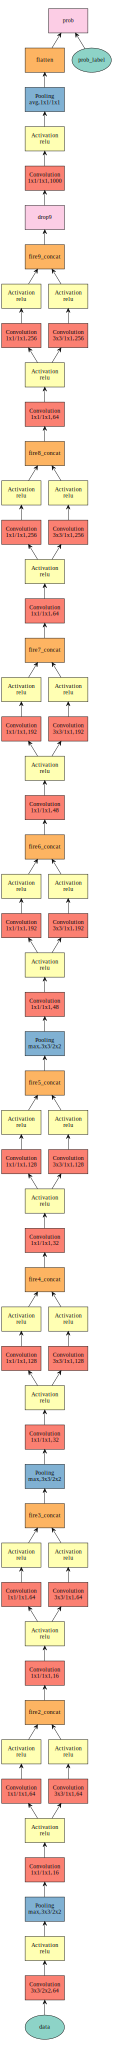

In [5]:
mx.viz.plot_network(sym)

For this model, we're only going to retrain the last convolutional output, and keep everything else. To do this, we grab everything up to the last layer we want (`fire9_concat`), bind the module t it, and set the parameters.

In [7]:
all_layers = sym.get_internals()
bottom_sym = all_layers['fire9_concat_output']
mod = mx.mod.Module(symbol=bottom_sym, context=ctx, label_names=None)
#Make sure this is >= the number of GPU's you are using
batch_size = 8
mod.bind(for_training=False, data_shapes=[('data', (batch_size,3,224,224))])
mod.set_params(arg_params, aux_params)

Next, we're going to load our data table created in the image extraction process.

In [40]:
data_table = pd.read_csv('data/data_file.csv', header=None, names=['set','category','filename','frames'])

In [41]:
data_table.head()

,set,category,filename,frames
0,train,BandMarching,v_BandMarching_g14_c06,208
1,train,BandMarching,v_BandMarching_g14_c05,217
2,train,BandMarching,v_BandMarching_g08_c07,140
3,train,BandMarching,v_BandMarching_g11_c06,392
4,train,BandMarching,v_BandMarching_g11_c07,247


Now we are ready to bulk-process our images through the network to extract the features at the layer we want. The only parameter you may want to tune is `step`:

This is the step we want to take across the frame sequence for feature extraction. Since these videos are 25-30 fps, we'd expect alot of redundant frames and so it's not necessary to extract features from all of them.

I'm extracting features from every other frame, but feel free to do much less than that (these take up alot of disk space).

This will take a few hours, depending on your device.

In [31]:
step = 2

In [ ]:
for video in data_table.itertuples(index=False, name=None):
    #set the path to save the features
    conv_path = './data/sequences/' + video[2] + '-features.npy'

    # Check if we already have it.
    if os.path.isfile(path):
        continue

    # Get the frames for this video.
    frame_path = './data/' + video[0] + '/' + video[1] + '/'
    filename = video[2]
    frames = sorted(glob(frame_path + filename + '*jpg'))

    # Skip frames with step size 
    frames = [frames[i] for i in range(0, len(frames), step)]

    # Now loop through and extract features to build the sequence.
    images = []
    for frame in frames:
        img = np.array(Image.open(frame).resize((224, 224),Image.BILINEAR))
        img = np.swapaxes(img, 0, 2)
        img = np.swapaxes(img, 1, 2)
        images.append(img)
    x = np.stack(images)

    # Get the prediction for the whole sequence
    nd_iter = mx.io.NDArrayIter(x, batch_size=x.shape[0])
    features = mod.predict(nd_iter)
    
    # Save the sequence.
    np.save(conv_path, features.asnumpy())

Great. Once this is done we can move on to fine-tuning the last layer.

## Fine-tuning

In [47]:
CONV_PATH = "data/sequences"

We'll load all the sequence file paths.

In [48]:
conv_feature_files = glob(path.join(CONV_PATH,'*npy'))

Each file contains the output of the final Fire module from squeezenet for the particular video in file name. The batch size is equivalent to the number of frames we extracted features for in each video.

### Input / Label Setup

For our purposes, we're going to limit ourselves to the following classes. 

Feel free to use all of them if you so wish, but we are going to load all of our features into memory and it might not be feasible on your machine if you use all of them.

In [42]:
classes = ['ApplyEyeMakeup', 'ApplyLipstick', 'BlowDryHair', 'BrushingTeeth', 'CuttingInKitchen', 'Hammering', 'HulaHoop', 
'JugglingBalls', 'JumpRope', 'Nunchucks', 'ShavingBeard', 'Typing', 'WritingOnBoard', 'YoYo', 'BlowingCandles',
'HandstandWalking', 'JumpingJack', 'Lunges', 'PushUps', 'WalkingWithDog', 'Haircut', 'HeadMassage','Drumming',
 'PlayingCello', 'PlayingFlute', 'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'PlayingViolin', 'Archery',
'Basketball', 'BenchPress', 'Biking', 'Billiards', 'Bowling', 'HorseRiding', 'Skiing']

# for all classes
# classes = list(data_table['category'].unique())

classes.sort()

Next we'll make mappings from category to integer and back again.

In [43]:
category2idx = {c.lower():i for i, c in enumerate(classes)}
idx2category = {i:c for c, i in zip(category2idx.keys(),category2idx.values())}

Next, we split train and test conv file paths:

In [44]:
#helper function to extract the category given the raw file path
extract_filename = lambda x: x.split('/')[-1].split('-')[0]

In [49]:
train_files = data_table['filename'][data_table['set']=='train']\
    [data_table['category'][data_table['set']=='train'].isin(classes)].values
test_files = data_table['filename'][data_table['set']=='test']\
    [data_table['category'][data_table['set']=='test'].isin(classes)].values

Then load the features. This will take awhile to load into memory, but will be much faster to train because of it.

In [ ]:
train_conv_features = [np.load(f) for f in conv_feature_files if extract_filename(f) in train_files]
train_conv_features = np.concatenate(train_conv_features, axis = 0)
test_conv_features = [np.load(f) for f in conv_feature_files if extract_filename(f) in test_files]
test_conv_features = np.concatenate(test_conv_features, axis = 0)

In [ ]:
train_conv_features.shape

In [ ]:
test_conv_features.shape

Next, we'll load our targets. For each train/test file, we're going to find the corresponding frames for that file from our table, divide it by the step size we took to determine how many of those frames we extracted, and append the corresponding label integer to our label list.

In [36]:
extract_category = lambda x: x.split('/')[-1].split('_')[1].lower()

train_categories = []
for f in conv_feature_files:
    filename = extract_filename(f)
    if filename in train_files:
        frames = data_table['frames'][data_table['filename']==filename].values[0] //step
        train_categories.append(frames*[category2idx[extract_category(f)]])
train_categories = np.concatenate(train_categories)

test_categories = []
for f in conv_feature_files:
    filename = extract_filename(f)
    if filename in test_files:
        frames = data_table['frames'][data_table['filename']==filename].values[0] //step
        test_categories.append(frames*[category2idx[extract_category(f)]])
test_categories = np.concatenate(test_categories)

## Model

Now we can train the top of the SqueezeNet model.

In [8]:
GPU_COUNT = 8
ctx = [mx.gpu(i) for i in range(GPU_COUNT)]

In [39]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

We have our data in memory, and now need to construct NDArray iterators.

The default `mx.io.NDArray` has an upper limit on the size of the array it can take, and the array we have in memory will likely be too large. To get around this, we're going to use the following wrapper put together by Boris Ivanovic (here)[https://github.com/apache/incubator-mxnet/issues/6195].

In [43]:
#BorisIvanovic
#https://github.com/apache/incubator-mxnet/issues/6195
class NDArrayPartitionedIter(mx.io.DataIter):
    def __init__(self, data, labels, batch_size, shuffle=False, 
                last_batch_handle='discard', data_partitions=10, 
                data_name='data', label_name='softmax_label'):
        data_partitions = min(data.shape[0], data_partitions)
        num_partition_datapoints = int(data.shape[0] / data_partitions)
        batch_size = min(batch_size, num_partition_datapoints)

        data_list = [data[num_partition_datapoints*i : num_partition_datapoints*(i+1)] for i in xrange(data_partitions)]
        labels_list = [labels[num_partition_datapoints*i : num_partition_datapoints*(i+1)] for i in xrange(data_partitions)]

        self.iter_list = [mx.io.NDArrayIter(nd.array(data_list[i]), nd.array(labels_list[i]), batch_size, 
                                            shuffle=shuffle, last_batch_handle=last_batch_handle, 
                                            data_name=data_name, label_name=label_name) for i in xrange(data_partitions)]

        self.curr_iter_idx = 0
        self.curr_iter = self.iter_list[self.curr_iter_idx]

    def next(self):
        try:
            return next(self.curr_iter)
        except StopIteration:
            if self.curr_iter_idx + 1 < len(self.iter_list):
                self.curr_iter_idx += 1
                self.curr_iter = self.iter_list[self.curr_iter_idx]
                return next(self.curr_iter)

            # If we've run out of iterators then
            # it's our own StopIteration time.
            raise

    def reset(self):
        # Reset each iterator to the beginning of its data.
        self.curr_iter_idx = 0
        for itr in self.iter_list:
            itr.hard_reset()

    def hard_reset(self):
        # Ignore roll over data and set to start.
        self.reset()
    
    @property
    def provide_data(self):
        return self.curr_iter.provide_data
    
    @property
    def provide_label(self):
        return self.curr_iter.provide_label

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

I'm using a batch size of 512.

In [ ]:
n = 512
nd_iter = NDArrayPartitionedIter(data=train_conv_features, labels=train_categories,\
                                batch_size=n, shuffle=True, data_partitions=10)
val_nd_iter = NDArrayPartitionedIter(data=test_conv_features, labels=test_categories,\
                                batch_size=n, shuffle=False, data_partitions=10)

We're also going to use the following class to allow for saving models that have the best test metric on evaluation data.

In [45]:
class EvalCallback(object):
    '''
    Early stopping
    
    pass an instance of the metric or the instance name to specify which metric to use for stopping
    
    1. epoch_end_callback: doesn't provide the metrics to the registered callback function, hence we can't use it to track
    metrics and save
    
    2. eval_end_callback: while it provides us with eval metrics, there isn't a clean way to stop the training, so the best
    thing to do is track and save the best model we have seen so far based on the metric and operator defined
    
    '''
    def __init__(self, model_prefix, metric, op="max", save_model=True, patience=0, delta=0):
        assert isinstance(metric, str) or isinstance(metric,mx.metric.EvalMetric), "Metric must be the name or the instance"
        self.metric_name = metric if isinstance(metric,str) else metric.name
        self.model_prefix = model_prefix
        self.eval_metrics = []
        self.save_model = save_model
        self.metric_op = np.less if op == "min" else np.greater
        self.best_metric = np.Inf if self.metric_op == np.less else -np.Inf
        self.delta = delta #min difference between metric changes
        self.patience = patience

    def get_loss_metrics(self):
        return self.eval_metrics
    
    def __call__(self, param):
        cur_epoch = param.epoch
        module_obj = param.locals['self']
        name_values = param.eval_metric.get_name_value()
        
        names, cur_values = zip(*name_values)
        if self.metric_name not in names:
            print("Metric %s not in model metrics: %s" % (self.metric_name, names))
            return
        name, cur_value = name_values[names.index(self.metric_name)]
        self.eval_metrics.append(cur_value)
        if cur_epoch >= self.patience:
        #print cur_value, self.best_metric, self.metric_op(cur_value - self.delta, self.best_metric)
            if self.metric_op(cur_value - self.delta, self.best_metric):
                self.best_metric = cur_value
                print('The best model found so far at epoch %05d with %s %s' % (cur_epoch, name, cur_value))
                if self.save_model:
                    logging.info('Saving the Model')    
                    module_obj.save_checkpoint(self.model_prefix, cur_epoch)
                    param_fname = '%s-%04d.params' % (self.model_prefix, cur_epoch)
                    os.rename(param_fname, '%s-0000.params' % self.model_prefix ) #rename the model

For our purposes, accuracy will do just fine.

In [199]:
save_best_model = EvalCallback(model_prefix="squeeze-top", metric='accuracy', op="max", save_model=True)

Next, we define the part of the model that we are fine-tuning, which is the last layer of SqueezeNet. 

This layer just maps the 512 features for each x,y input to the number of classes desired, and average pools across the height/width dimensions. This results in a single vector that we can pass through a softmax output to get class predictions.

In [46]:
def squeeze_top(ctx, num_classes, p=0.5):
    data = mx.sym.Variable('data')
    x = mx.sym.Dropout(data, p=p)
    x = mx.sym.Convolution(x, kernel=(1, 1), stride=(1, 1), num_filter=num_classes, name='conv10')
    x = mx.sym.Pooling(x, global_pool=True, kernel=(1, 1), pad=(1, 1),
                       pool_type="avg", pooling_convention="full", stride=(1, 1), name='pool10')
    x = mx.sym.Flatten(x, name='flatten')
    out = mx.sym.SoftmaxOutput(x, name='softmax')
    return mx.mod.Module(out, context=ctx)

Our output size is the number of clases we have.

Once we've built our model, we bind, initialize, and train using Adam.

In [ ]:
mod = squeeze_top(ctx, len(classes))
mod.bind(data_shapes=nd_iter.provide_data, label_shapes=nd_iter.provide_label)
mod.init_params(mx.init.Xavier())
mod.init_optimizer(optimizer='adam', optimizer_params=(('learning_rate', 1e-3),))
mod.fit(nd_iter, 
        num_epoch=20,
        eval_data=val_nd_iter,
        eval_metric = ['acc', mx.metric.TopKAccuracy(5), mx.metric.TopKAccuracy(10)],
        batch_end_callback = mx.callback.Speedometer(n, 500),
        eval_end_callback = save_best_model)

I've been able to get ~60% accuracy, 85% top 5 accuracy, and 95% top 10 accuracy on the validation set. This is nowhere near state of the art on this data set, but this data set is for **video** classification. Here, we're attempting to build a simple action recognition model using only images. 

Qualitatively, we know that frames are not enough. We also know that there are likely to be alot of redundant or useless frames; on the test set, the model is able to predict these useless frames accurately due to data leakage (i.e. it recognizes the frame as belonging to the same video as action X) but on the test set it isn't able to do so.

## Reattach Top

Finally, our last step is to reattach the top layer we fine-tuned to the rest of the model.

First we'll load the params for the top layer.

In [3]:
top_sym, top_arg_params, top_aux_params = mx.model.load_checkpoint('squeeze_top', 0)

Then we extend the bottom symbol to include the top again, and bind the module.

In [33]:
x = mx.sym.Convolution(bottom_sym, kernel=(1, 1), stride=(1, 1), num_filter=len(classes), name='conv10')
x = mx.sym.Pooling(x, global_pool=True, kernel=(1, 1), stride=(1, 1), pool_type="avg", pooling_convention="full", name='pool10')
x = mx.sym.Flatten(x, name='flatten')
out = mx.sym.SoftmaxOutput(x, name='softmax', multi_output=False)
mod = mx.mod.Module(out, data_names=['data'], context=mx.cpu(), label_names=None)
mod.bind([('data', (1,3,224,224))], for_training=False, )

Finally, we extend the squeezenet params with those we just trained, and load them into the module.

In [34]:
seq_arg_params = arg_params.copy()
seq_arg_params.update(top_arg_params)
seq_aux_params = aux_params.copy()
seq_aux_params.update(top_aux_params)
mod.set_params(seq_arg_params, seq_aux_params, allow_missing=True, allow_extra=True)

Now let's save it:

In [35]:
mod.save_checkpoint('action_recognition_v2.0', 0)

In the future, we can just load this model as usual:

In [101]:
sym, arg_params, aux_params = mx.model.load_checkpoint('action_recognition', 0)
mod = mx.mod.Module(sym, data_names=['data'], context=mx.cpu(), label_names=None)
mod.bind([('data', (1,3,224,224))], for_training=False, )
mod.set_params(arg_params, aux_params)

And now we can make a predictions!

In [15]:
import urllib, cStringIO
def predict_url(url, mod):
    file = cStringIO.StringIO(urllib.urlopen(url).read())
    original_img = Image.open(file)
    img = np.array(original_img.resize((224, 224),Image.BILINEAR))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = np.expand_dims(img, axis=0)
    batch = mx.io.DataBatch([nd.array(img)])
    mod.forward(batch)
    out = mod.get_outputs()[0]
    category = idx2category[np.argmax(out[0].asnumpy())]
    prob = np.max(out[0].asnumpy())
    draw = ImageDraw.Draw(original_img)
    draw.text((5, 5),"%s, P:%0.3f" % (category,prob),(255,255,255))
    return original_img

In [18]:
mod.output_shapes

[('softmax_output', (1, 37L))]

Let's test this out on sitar master Ravi Shankar:

Source: https://upload.wikimedia.org/wikipedia/commons/9/90/Dia5275_Ravi_Shankar.jpg

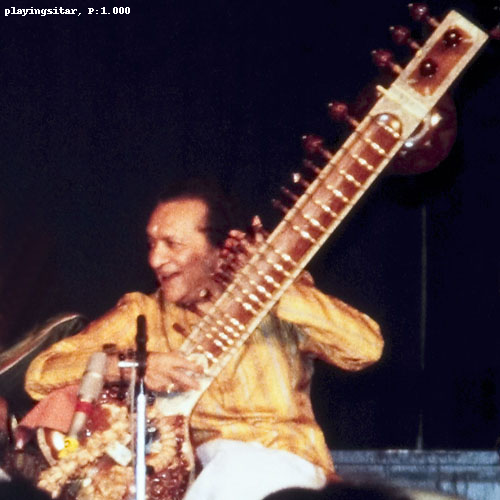

In [30]:
predict_url('https://upload.wikimedia.org/wikipedia/commons/9/90/Dia5275_Ravi_Shankar.jpg', mod)

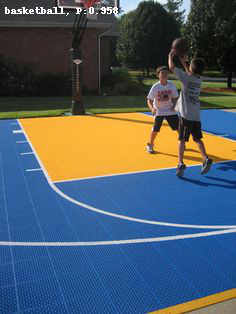

In [31]:
predict_url("https://i.pinimg.com/236x/db/fa/8d/dbfa8d8214e8209215d0eb74df242828--backyard-basketball-court-indoor-basketball.jpg", mod)

Looks great!